# Imports

In [280]:
import os
import numpy as np
import imghdr
from PIL import Image
import imageio

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display

#Tensorflow version 2.7.0
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


# Tensorflow check

In [281]:
print('GPU list ', tf.config.list_physical_devices('GPU'))
print('Tensorflow verison :', tf.__version__)

GPU list  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow verison : 2.7.0


# JPEG files errors drop

In [282]:

def DropErroredFiles(images_path):
    images = os.listdir(dog_data_dir)

    i = 0
    for image in images:
        image = os.path.join(dog_data_dir, image)
        if not imghdr.what(image) == "jpeg":
            #os.remove(image)
            i+=1
    print(i)

# Data load

In [283]:
def LoadImageDataSet(data_dir, x_pixel, y_pixel):
    train_data = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed = 123,
        image_size=(x_pixel, y_pixel))
    
    val_data = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed = 123,
        image_size=(x_pixel, y_pixel))
    
    return train_data, val_data

#images_dir = os.path.realpath("C:/Users/emeri/data/DogImages")
#train_data, val_data = LoadImageDataSet(images_dir, 32, 32)

# Data Infos

In [284]:
def PrintDataInfo(data):
    for image_batch, labels_batch in data.take(1):
        print('Batch shape :', image_batch.shape)
        print('Batch label shape :', labels_batch.shape)

    print('Class names :', train_data.class_names)

#PrintDataInfo(train_data)

# Data samples image display

In [285]:
def DisplayDataSample(data):
    class_names = data.class_names

    for image_batch, labels_batch in data.take(1):
        plt.figure(figsize=(10, 10))
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            print(image_batch[i].dtype)
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            plt.title(class_names[labels_batch[i]])
            plt.axis("off")

#DisplayDataSample(train_data)

In [286]:
def DisplayDataSampleGenerator(data):
    plt.figure(figsize=(10, 10))
    typeData = data.dtype
    print(typeData)
    i = 0
    for image_batch in data:
        if i == 4:
            break

        ax = plt.subplot(2, 2, i + 1)
        if (np.max(image_batch.numpy()) > 150):
            plt.imshow(image_batch.numpy().astype(np.float64)/255)
        else:
            plt.imshow(image_batch.numpy().astype(np.float64))
        plt.title('Generated image')
        plt.axis("off")
        
        i+=1
    plt.show()
        

# Random noise generator

In [287]:
def CreateBatchNoiseInput(nbr_samples, x, y):
    #randNumpyImages = np.random.randint(256,size=(nbr_samples,128,128,3)).astype(np.uint8)

    #noise = tf.data.Dataset.from_tensor_slices(randNumpyImages).batch(nbr_samples)
    noise = tf.random.normal([nbr_samples,x,y,3])
    return noise

#CreateBatchNoiseInput(10)

# Model (Generator)

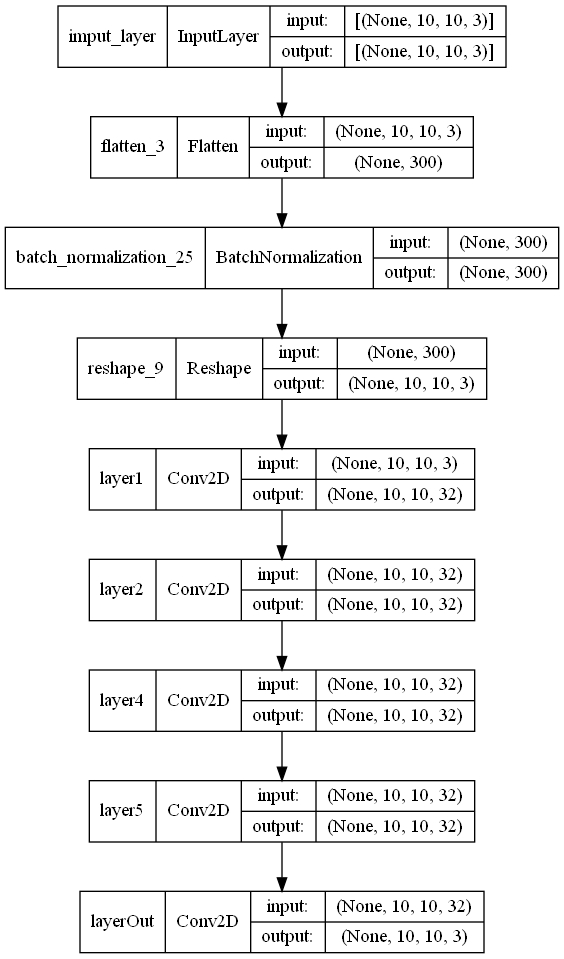

In [288]:
def GetModelGenerator(x, y):
    input = tf.keras.Input(shape=(x, y, 3), name='imput_layer')#128,128,3))
    flat = tf.keras.layers.Flatten()(input)
    layernorm = tf.keras.layers.BatchNormalization()(flat)
    reshape = tf.keras.layers.Reshape((x, y, 3))(layernorm)

    layer1 = tf.keras.layers.Conv2D(filters = 32, padding='same', kernel_size=3, activation='relu', name='layer1')(reshape)
    layer2 = tf.keras.layers.Conv2D(filters = 32, padding='same', kernel_size=3, activation='relu', name='layer2')(layer1)
    #layer3 = tf.keras.layers.Add()([layer1,layer2])
    layer4 = tf.keras.layers.Conv2D(filters = 32, padding='same', kernel_size=3, activation='relu', name='layer4')(layer2)
    layer5 = tf.keras.layers.Conv2D(filters = 32, padding='same', kernel_size=3, activation='relu', name='layer5')(layer4)
    #layer6 = tf.keras.layers.Add()([layer4,layer5])
    layerOutput = tf.keras.layers.Conv2D(filters = 3, padding='same', kernel_size=3, activation='sigmoid', name='layerOut')(layer5)
    model = tf.keras.Model(inputs=[input], outputs=[layerOutput])
    
    return model

tf.keras.utils.plot_model(GetModelGenerator(10,10), show_shapes=True)

In [289]:
#V2
"""def GetModelGenerator(x, y):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model
tf.keras.utils.plot_model(GetModelGenerator(28,28), show_shapes=True)
"""

"def GetModelGenerator(x, y):\n    model = tf.keras.Sequential()\n    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))\n    model.add(tf.keras.layers.BatchNormalization())\n    model.add(tf.keras.layers.LeakyReLU())\n\n    model.add(tf.keras.layers.Reshape((7, 7, 256)))\n    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size\n\n    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))\n    assert model.output_shape == (None, 7, 7, 128)\n    model.add(tf.keras.layers.BatchNormalization())\n    model.add(tf.keras.layers.LeakyReLU())\n\n    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))\n    assert model.output_shape == (None, 14, 14, 64)\n    model.add(tf.keras.layers.BatchNormalization())\n    model.add(tf.keras.layers.LeakyReLU())\n\n    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_

In [290]:
generatorTest = GetModelGenerator(32, 32)
noise = CreateBatchNoiseInput(32, 32, 32)
generated_images = generatorTest(noise, training=True)
generated_images.shape

TensorShape([32, 32, 32, 3])

# Model (Discriminator)

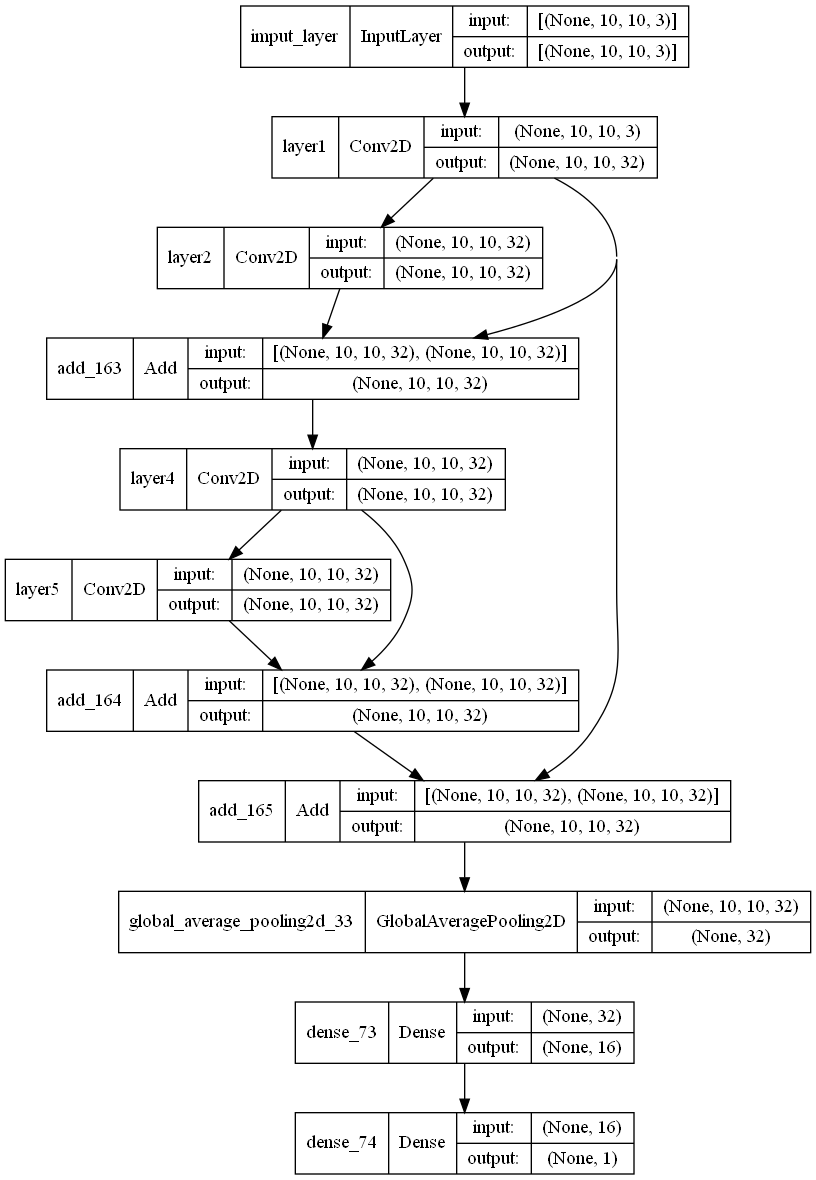

In [291]:
def GetModelDiscriminator(x, y):
    input = tf.keras.Input(shape=(x,y,3), name='imput_layer')

    layer1 = tf.keras.layers.Conv2D(filters = 32, padding='same', kernel_size=3, activation='relu', name='layer1')(input)
    layer2 = tf.keras.layers.Conv2D(filters = 32, padding='same', kernel_size=3, activation='relu', name='layer2')(layer1)
    layer3 = tf.keras.layers.Add()([layer1,layer2])
    layer4 = tf.keras.layers.Conv2D(filters = 32, padding='same', kernel_size=3, activation='relu', name='layer4')(layer3)
    layer5 = tf.keras.layers.Conv2D(filters = 32, padding='same', kernel_size=3, activation='relu', name='layer5')(layer4)
    layer6 = tf.keras.layers.Add()([layer4,layer5])
    layer7 = tf.keras.layers.Add()([layer1,layer6])
    pool = tf.keras.layers.GlobalAveragePooling2D()(layer7)
    layer_fc = tf.keras.layers.Dense(16, activation='relu')(pool)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(layer_fc)

    model = tf.keras.Model(inputs=[input], outputs=[output])
    
    return model

tf.keras.utils.plot_model(GetModelDiscriminator(10,10), show_shapes=True)

# Credit (**) https://www.tensorflow.org/tutorials/generative/dcgan#define_the_loss_and_optimizers

# ** Discriminator Loss Function

In [309]:
def discriminator_loss(cross_entropy, real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# ** Generator Loss Function

In [310]:
def generator_loss(cross_entropy, fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# ** Train Step Function

In [311]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(generator, generator_loss, generator_optimizer, discriminator, discriminator_loss, discriminator_optimizer, cross_entropy, images, batch_size, x_pixels, y_pixels):
    noise = CreateBatchNoiseInput(batch_size, x_pixels, y_pixels)#tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        generated_images = generator(noise, training=True)
        generated_images = generated_images*255
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(cross_entropy, fake_output)
        disc_loss = discriminator_loss(cross_entropy, real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# ** Train Function

In [312]:
def train(generator, generator_loss, discriminator, discriminator_loss, dataset, epochs, batch_size, x_pixels, y_pixels):

    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
    
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch, label_batch in dataset:
            train_step(generator, generator_loss, generator_optimizer, discriminator, discriminator_loss, discriminator_optimizer, cross_entropy, image_batch, batch_size, x_pixels, y_pixels)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)

        noise = CreateBatchNoiseInput(200, x_pixels, y_pixels)
        generated_images = generator(noise, training=False)
        generated_images = generated_images*255
        DisplayDataSampleGenerator(generated_images)
        
        generated_images = generator(noise, training=False)
        generated_images = generated_images*255
        fake_output = discriminator(generated_images, training=False)
        
        gen_loss = generator_loss(cross_entropy, fake_output)

        print('-----> Loss generator :', gen_loss)
        
        noise2 = CreateBatchNoiseInput(10, x_pixels, y_pixels)
        generated_images2 = generator(noise2, training=False)
        generated_images2 = generated_images2*255
        fake_output2 = discriminator(generated_images2, training=False)
        print('-----> 10 Fake disc pred : ', fake_output2)

        # Save the model every 15 epochs
        #if (epoch + 1) % 15 == 0:
        #    checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    return generator, discriminator

    # Generate after the final epoch
    #display.clear_output(wait=True)
    #generate_and_save_images(generator, epochs, seed)

# Workflow

<dtype: 'float32'>


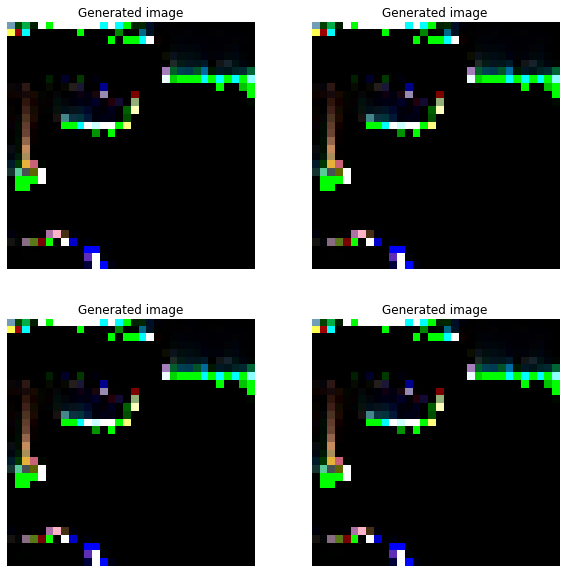

-----> Loss generator : tf.Tensor(33.61114, shape=(), dtype=float32)
-----> 10 Fake disc pred :  tf.Tensor(
[[2.4515512e-15]
 [2.4398608e-15]
 [2.4685742e-15]
 [2.4541615e-15]
 [2.4388094e-15]
 [2.4655719e-15]
 [2.4267820e-15]
 [2.4620476e-15]
 [2.4740987e-15]
 [2.4669079e-15]], shape=(10, 1), dtype=float32)
Time for epoch 5000 is 5.85668420791626 sec


In [313]:
def Workflow():
    EPOCHS = 5000
    noise_dim = 1000
    num_examples_to_generate = 16
    seed = 2022
    BATCH_SIZE = 32

    x_pixels = 32
    y_pixels = 32
    
    #Root images path
    images_dir = os.path.realpath("C:/Users/emeri/data/DogImages")
    #images_dir = os.path.realpath("C:/Users/emeri/data/HandWriting")

    #Load Images
    train_dog_images, val_dog_images = LoadImageDataSet(images_dir, x_pixels, y_pixels)

    #Model Discriminator
    model_disc = GetModelDiscriminator(x_pixels, y_pixels)

    #Model Generator
    model_gen = GetModelGenerator(x_pixels, y_pixels)

    #Train
    model_gen, model_disc = train(
        model_gen,
        generator_loss,
        model_disc,
        discriminator_loss,
        train_dog_images,
        EPOCHS, BATCH_SIZE, 
        x_pixels,
        y_pixels)
    
    return model_gen, model_disc
    
model_gen, model_disc = Workflow()

In [266]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


In [184]:
noise = CreateBatchNoiseInput(4)
generated_images = model_gen(noise, training=False)
generated_images.shape
DisplayDataSampleGenerator(generated_images)

TypeError: CreateBatchNoiseInput() missing 2 required positional arguments: 'x' and 'y'

In [267]:
images_dir = os.path.realpath("C:/Users/emeri/data/HandWriting")
train_data, val_data = LoadImageDataSet(images_dir, 32, 32)

Found 28000 files belonging to 1 classes.
Using 22400 files for training.
Found 28000 files belonging to 1 classes.
Using 5600 files for validation.


In [272]:
test = None
for val_data, labels_batch in train_data.take(1):
    test = model_disc(image_batch, training=False)

In [273]:
test

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.9999999 ],
       [0.9999999 ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.99999833],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ]], dtype=float32)>

In [274]:
noise2 = CreateBatchNoiseInput(10, 32, 32)

In [275]:
noise2

<tf.Tensor: shape=(10, 32, 32, 3), dtype=float32, numpy=
array([[[[ 6.00633681e-01,  1.00742662e+00,  2.67208248e-01],
         [ 9.26486611e-01, -1.19923210e+00, -8.14579785e-01],
         [ 2.30967402e+00, -4.76373494e-01,  8.20691764e-01],
         ...,
         [-3.20238292e-01, -1.17219472e+00,  4.04601514e-01],
         [ 6.33313239e-01, -1.41049087e+00, -1.43585324e-01],
         [ 5.93681991e-01,  6.03566878e-02,  3.68165970e-01]],

        [[ 4.17398572e-01, -1.56035733e+00, -6.98811591e-01],
         [-1.21935809e+00, -1.36927271e+00, -1.58004820e+00],
         [-1.31092942e+00,  8.18082511e-01,  7.55344570e-01],
         ...,
         [-8.04234982e-01,  5.18600643e-01,  1.55661988e+00],
         [-1.79794884e+00, -3.43861371e-01, -1.34996283e+00],
         [-2.59012508e+00, -3.99378896e-01,  5.70237100e-01]],

        [[-7.59667382e-02, -4.11370128e-01,  8.55538368e-01],
         [ 1.88985741e+00, -1.06026447e+00,  6.14201605e-01],
         [-2.94410795e-01, -1.42769611e+00,